In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from SimLib import config_sim as conf
from SimLib import sipm_mapping as DAQ
import sys
#sys.path.append("/home/viherbos/GITHUB/PETALO_analysis")
import fit_library
import scipy.signal as sc
import itertools as it
import multiprocessing as mp
import time
#import TOF_library as T_lib

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2   


# Convolution Test

#timestamp, accu_table, conv_table = TDC.TDC(25,-1,1)   # Event, Time Window for TDC, TE_TDC
#print("%d" % np.min(timestamp[np.argwhere(timestamp>0)]))
fig = plt.figure()
plt.plot(TDC.conv_table[:,2729])
np.argmax(TDC.part_acc)



time = 20000
first_SiPM = 1000
phi_o = np.zeros(Matrix_O.shape)
# Data Matrix Composition
for i in range(Matrix_O.shape[0]):
    for j in range(Matrix_O.shape[1]):
        phi_o[i,j] = accu_table[time,int(Matrix_O[i,j])]

fig = plt.figure(figsize=(10,1.5))
plt.imshow(phi_o)
plt.show()
print(np.min(timestamp[np.argwhere(timestamp>0)])*5)

# Energy Computation Test

Energy = T_lib.ENERGY_compute("/volumedisk0/home/viherbos/DAQ_data/","petit_ring_tof_high_stat.pet.h5",SIPM,Matrix_O)
Energy(100)

# Energy Computation with Multiprocessing

# Multiprocessing
Energy = T_lib.ENERGY_compute("/volumedisk0/home/viherbos/DAQ_data/","petit_ring_tof_high_stat.pet.h5",SIPM,Matrix_O)   

def ENER_comp_wrapper(args):   
    return Energy(args)

pool_size = mp.cpu_count() 
pool = mp.Pool(processes=12)
#pool_output = pool.map(DAQ_map, [i for i in L1_Slice])
pool_output = pool.map(ENER_comp_wrapper, [i for i in range(0,25000)])
pool.close()
pool.join()



Energy_v = np.array([pool_output[i] for i in range(len(pool_output))]).reshape(-1)

fig2 = plt.figure()
fit = fit_library.gauss_fit()
data = Energy_v[Energy_v>100]
fit(data,50)
fit.plot(axis = fig2.add_subplot(111),
     title = "Energy Spectrum (Singles)",
     xlabel = "Photons",
     ylabel = "Hits",
     res=False, 
     fit=True)

In [2]:
TE_range   = np.array(pd.read_hdf('/home/viherbos/DAQ_DATA/NEUTRINOS/PETit-ring/7mm_pitch/TOF_MTETDC_Mmeans.h5',
                       key='TE_range',dtype='float')).reshape(-1)
mean_range = np.array(pd.read_hdf('/home/viherbos/DAQ_DATA/NEUTRINOS/PETit-ring/7mm_pitch/TOF_MTETDC_Mmeans.h5',
                       key='mean_range',dtype='float')).reshape(-1)

In [3]:
time_bin = 5

def plot_tof(i,j,fig,TOF_data,TE_range=TE_range, mean_range=mean_range, 
             time_bin=time_bin,fit_margins=[15,30],esq=420,limits=[-100,100]): 
    data = TOF_data[:,i].reshape(-1) 
    data = np.abs(time_bin*data[(data>limits[0])*(data<limits[1])])
    sign = [np.random.choice((-1, 1)) for i in range(len(data))]
    data = data*sign
    fit(data,fit_margins)
    fit.plot(axis = fig.add_subplot(111),
         title = "Time of Flight - Threshold = "+str(TE_range[j])+"pe"+" - "+"Average of first "+ str(mean_range[i])+ " SiPM" ,
         xlabel = "Time Stamp in picoseconds",
         ylabel = "Hits",
         res=False, 
         fit=True)
    print("Valid Events = %d" % (data.shape))
    print(fit.bins)

fwhm_v = np.zeros((len(mean_range),len(TE_range)))
fwhmE_v = np.zeros((len(mean_range),len(TE_range)))

In [387]:
TE_TDC = 0
mean   = 8
time_bin = 5

TOF_data = np.array(pd.read_hdf('/home/viherbos/DAQ_DATA/NEUTRINOS/PETit-ring/7mm_pitch/TOF_MTETDC_Mmeans.h5',
                       key='TOF_data'+str(TE_TDC),dtype='float'))
fit = fit_library.gauss_fit()
fig1 = plt.figure(figsize=(7,7)) 

plot_tof(mean,TE_TDC,fig1,TOF_data,fit_margins=[14,30],esq=109,limits=[-330,330])

fwhm_v[mean,TE_TDC] = fit.coeff[2]*2.35
fwhmE_v[mean,TE_TDC] = fit.perr[2]*2.35

plt.show()

IndexError: index 8 is out of bounds for axis 1 with size 8

<Figure size 504x504 with 0 Axes>

<IPython.core.display.Javascript object>


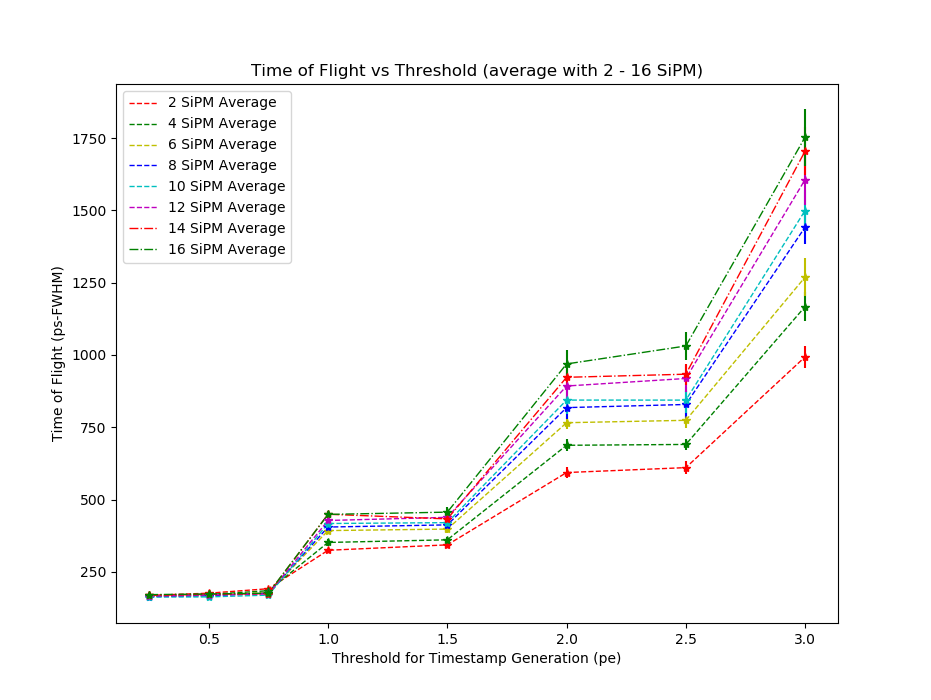

In [403]:
fig1 = plt.figure(figsize=(7,7)) 
plt.plot(TE_range, np.abs(fwhm_v[0,:].reshape(-1)), 'r--', linewidth=1, label="2 SiPM Average")
plt.errorbar(TE_range, np.abs(fwhm_v[0,:].reshape(-1)), fmt='r*', yerr=fwhmE_v[0,:])

plt.plot(TE_range, np.abs(fwhm_v[1,:].reshape(-1)), 'g--', linewidth=1, label="4 SiPM Average")
plt.errorbar(TE_range, np.abs(fwhm_v[1,:].reshape(-1)), fmt='g*', yerr=fwhmE_v[1,:])

plt.plot(TE_range, np.abs(fwhm_v[2,:].reshape(-1)), 'y--', linewidth=1, label="6 SiPM Average")
plt.errorbar(TE_range, np.abs(fwhm_v[2,:].reshape(-1)), fmt='y*', yerr=fwhmE_v[2,:])

plt.plot(TE_range, np.abs(fwhm_v[3,:].reshape(-1)), 'b--', linewidth=1, label="8 SiPM Average")
plt.errorbar(TE_range, np.abs(fwhm_v[3,:].reshape(-1)), fmt='b*', yerr=fwhmE_v[3,:])

plt.plot(TE_range, np.abs(fwhm_v[4,:].reshape(-1)), 'c--', linewidth=1, label="10 SiPM Average")
plt.errorbar(TE_range, np.abs(fwhm_v[4,:].reshape(-1)), fmt='c*', yerr=fwhmE_v[4,:])

plt.plot(TE_range, np.abs(fwhm_v[5,:].reshape(-1)), 'm--', linewidth=1, label="12 SiPM Average")
plt.errorbar(TE_range, np.abs(fwhm_v[5,:].reshape(-1)), fmt='m*', yerr=fwhmE_v[5,:])

plt.plot(TE_range, np.abs(fwhm_v[6,:].reshape(-1)), 'r-.', linewidth=1, label="14 SiPM Average")
plt.errorbar(TE_range, np.abs(fwhm_v[6,:].reshape(-1)), fmt='r*', yerr=fwhmE_v[6,:])

plt.plot(TE_range, np.abs(fwhm_v[7,:].reshape(-1)), 'g-.', linewidth=1, label="16 SiPM Average")
plt.errorbar(TE_range, np.abs(fwhm_v[7,:].reshape(-1)), fmt='g*', yerr=fwhmE_v[7,:])

plt.xlabel('Threshold for Timestamp Generation (pe)')
plt.ylabel('Time of Flight (ps-FWHM)')
plt.title('Time of Flight vs Threshold (average with 2 - 16 SiPM)')
plt.legend()

plt.show()


In [394]:
fwhm_v

array([[  168.82207561,  -176.35188903,   191.85752076,   324.73708628,
         -343.44916193,  -593.54818788,   610.50610942,   993.48257287],
       [  166.42157261,  -171.93546522,   184.95644154,   351.7784805 ,
         -360.89093324,   687.78561157,   690.69014048, -1167.27072097],
       [  165.25874379,   168.93770151,  -178.72507443,   392.82034714,
          398.02977188,  -765.8196594 ,   774.12742008, -1269.30754643],
       [ -164.47507923,  -167.29844531,  -176.61279717,  -405.09018433,
          412.53541356,   818.03260302,  -828.88492732, -1442.20219639],
       [ -162.89252631,   163.55894066,   169.72069243,   417.30269315,
          420.28496718,  -844.10578167,   843.998465  , -1499.52243885],
       [ -166.10203898,   169.73799176,  -173.89425036,  -427.73611192,
         -438.63873194,  -892.74206003,   918.74529865, -1606.50522453],
       [ -168.65153398,  -172.42848999,  -175.04304431,  -449.31191204,
          433.23667679,  -922.84098705,   933.57857258, -1

In [392]:
fwhmE_v

array([[ 2.53706971,  4.26578085,  3.10200943,  5.47285813,  6.94379082,
        18.87038261, 21.74391047, 38.25492328],
       [ 4.18877997,  4.88766013,  4.99714016, 10.93668783, 11.30595695,
        20.75802817, 18.41648891, 49.5460343 ],
       [ 4.99854701,  3.77393561,  5.48059191, 12.24268462, 12.4420543 ,
        23.32683089, 25.24794602, 64.62350845],
       [ 3.96779459,  4.15578713,  2.66571592, 11.11350729, 10.60990533,
        38.15106619, 46.55481716, 58.98272167],
       [ 4.90268283,  4.27565173,  2.41885105, 17.26116394,  7.82256221,
        47.78104626, 46.07111165, 70.91459554],
       [ 5.31718713,  5.24378782,  4.73645947, 13.19753559, 13.7037996 ,
        45.52774172, 45.45906423, 89.15322533],
       [ 4.88241777,  4.47169949,  6.59414794, 11.5657047 , 14.6468127 ,
        27.37231567, 36.32865438, 82.55861301],
       [ 5.34568501,  4.46661125,  4.24286347, 13.2120959 , 16.22978102,
        47.06846604, 49.2961168 , 98.99591542]])

with pd.HDFStore("RESULTS.h5",complevel=9, complib='zlib') as store:
    fwhm_v = pd.DataFrame(data=fwhm_v)
    fwhmE_v = pd.DataFrame(data=fwhmE_v)
    TE_range = pd.DataFrame(data=TE_range)
    mean_range = pd.DataFrame(data=mean_range)
    store.put('FWHM',fwhm_v)
    store.put('FWHM_E',fwhmE_v)
    store.put('TE_range',TE_range)
    store.put('mean_range',mean_range)
    store.close()

In [6]:
fwhm_v = np.array(pd.read_hdf('RESULTS.h5',key='FWHM',dtype='float'))
fwhmE_v = np.array(pd.read_hdf('RESULTS.h5',key='FWHM_E',dtype='float'))
TE_range = np.array(pd.read_hdf('RESULTS.h5',key='TE_range',dtype='float'))
mean_range = np.array(pd.read_hdf('RESULTS.h5',key='mean_range',dtype='float'))

In [7]:
fwhm_v

array([[  168.82207561,  -176.35188903,   191.85752076,   324.73708628,
         -343.44916193,  -593.54818788,   610.50610942,   993.48257287],
       [  166.42157261,  -171.93546522,   184.95644154,   351.7784805 ,
         -360.89093324,   687.78561157,   690.69014048, -1167.27072097],
       [  165.25874379,   168.93770151,  -178.72507443,   392.82034714,
          398.02977188,  -765.8196594 ,   774.12742008, -1269.30754643],
       [ -164.47507923,  -167.29844531,  -176.61279717,  -405.09018433,
          412.53541356,   818.03260302,  -828.88492732, -1442.20219639],
       [ -162.89252631,   163.55894066,   169.72069243,   417.30269315,
          420.28496718,  -844.10578167,   843.998465  , -1499.52243885],
       [ -166.10203898,   169.73799176,  -173.89425036,  -427.73611192,
         -438.63873194,  -892.74206003,   918.74529865, -1606.50522453],
       [ -168.65153398,  -172.42848999,  -175.04304431,  -449.31191204,
          433.23667679,  -922.84098705,   933.57857258, -1

In [8]:
mean_range

array([[ 2],
       [ 4],
       [ 6],
       [ 8],
       [10],
       [12],
       [14],
       [16]])

Text(0.5,1,'Time of Flight vs Number of SiPM AVG (Threshold = 0.5 pe)')

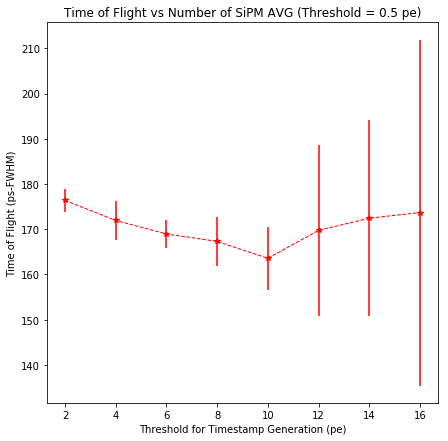

In [11]:
fig2 = plt.figure(figsize=(7,7))

plt.plot(mean_range, np.abs(fwhm_v[:,1].reshape(-1)), 'r--', linewidth=1, label="0.5 pe Threshold")
plt.errorbar(mean_range, np.abs(fwhm_v[:,1].reshape(-1)), fmt='r*', yerr=fwhmE_v[0,:])

plt.xlabel('Threshold for Timestamp Generation (pe)')
plt.ylabel('Time of Flight (ps-FWHM)')
plt.title('Time of Flight vs Number of SiPM AVG (Threshold = 0.5 pe)')